In [19]:
import pandas as pd
import numpy as np
import scipy.stats as sp
import seaborn as sns
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

#### 1) загружаем данные

In [3]:
path = 'https://stepik.org/media/attachments/lesson/396008/hw_bootstrap.csv'

In [64]:
#??pd.read_csv

In [4]:
df = pd.read_csv(path, sep = ';', usecols = ['value', 'experimentVariant'], decimal = ',')
df.head()

,value,experimentVariant
0,10.380495,Control
1,9.546867,Control
2,11.088215,Control
3,10.147274,Control
4,9.789808,Control


In [4]:
df.dtypes

value                float64
experimentVariant     object
dtype: object

In [5]:
df.experimentVariant.value_counts()

Control      500
Treatment    500
Name: experimentVariant, dtype: int64

#### 2) смотрим на распределения в тесте и контроле

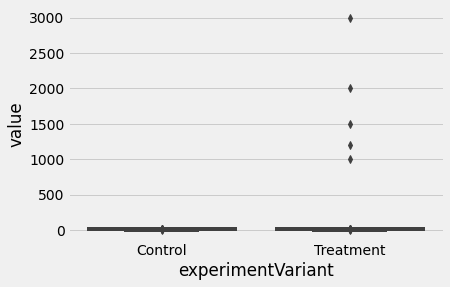

In [5]:
sns.boxplot(x = 'experimentVariant', y = 'value', data = df) #сложно оценить из-за выбросов

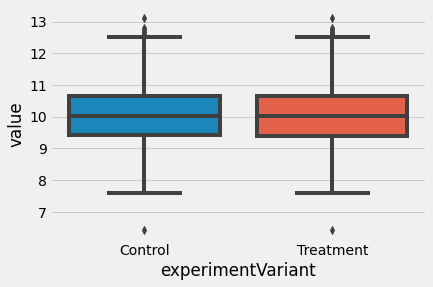

In [7]:
sns.boxplot(x = 'experimentVariant', y = 'value', data = df[df.value < 500])
#без экстремальных значений видно, что в остальном распределения теста и контроля очень схожи

#### 3) разделяем датасет на 2 выборки, смотрим основные статистики

In [9]:
test_sample = df[df.experimentVariant == 'Treatment'].value
control_sample = df[df.experimentVariant == 'Control'].value

In [13]:
test_sample.describe(), '----------------------------', control_sample.describe() 

(count     500.000000
 mean       27.321499
 std       186.557011
 min         6.436541
 25%         9.421968
 50%        10.025847
 75%        10.675721
 max      3000.000000
 Name: value, dtype: float64,
 '----------------------------',
 count    500.000000
 mean      10.026867
 std        0.979377
 min        6.436541
 25%        9.411024
 50%       10.018465
 75%       10.664879
 max       13.130346
 Name: value, dtype: float64)

#### 4) функция бутсрэпа

In [14]:
def bootstrap (data_a, data_b, iters=1000, conf_lvl=0.95, stat=np.mean):
    data_boot = []
    n = max(len(data_a), len(data_b))
    
    for i in tqdm(range(iters)):
        a = data_a.sample(n, replace=True).values
        b = data_b.sample(n, replace=True).values
        data_boot.append(stat(a-b))
        data_boot_pd = pd.DataFrame(data_boot)

    p_value_crit = 1 - conf_lvl
    left_quant = p_value_crit/2
    right_quant = 1 - left_quant
    quantiles = data_boot_pd.quantile([left_quant, right_quant])

    p1=sp.norm.cdf(x=0, loc= np.mean(data_boot), scale=np.std(data_boot))
    p2=sp.norm.cdf(x=0, loc=-np.mean(data_boot), scale=np.std(data_boot))

    p_value = min(p1, p2) * 2

    # Визуализация
    plt.hist(data_boot_pd[0], bins = int(np.sqrt(n)))

    plt.vlines(quantiles, ymin=0, ymax=20,linestyle='--')
    plt.xlabel('data_boot')
    plt.ylabel('frequency')
    plt.title("Histogram of data_boot")
    plt.show()

    return 'p_value is {0:f}'.format(p_value)

#### 5) применяем статтесты

In [32]:
sp.mannwhitneyu(test_sample, control_sample)

MannwhitneyuResult(statistic=124189.5, pvalue=0.42960742912427896)

In [17]:
#sp.ttest_ind(test_sample, control_sample)

Ttest_indResult(statistic=2.0729020485356604, pvalue=0.038437593613498765)

In [ ]:
#bootstrap(control_sample, control_sample)

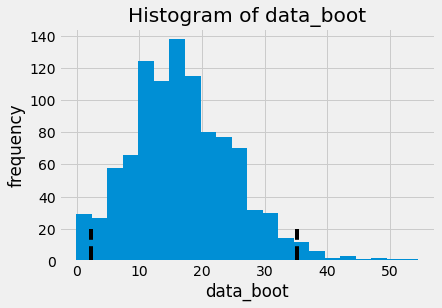

'p_value is 0.039315'

In [21]:
bootstrap(test_sample, control_sample)

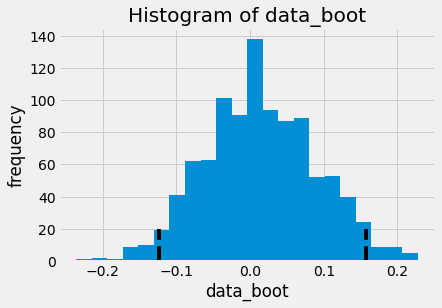

'p_value is 0.843408'

In [35]:
bootstrap(test_sample, control_sample, stat=np.median)

#### 6) выводы

**Нулевая гипотеза - различий между группами нет**

**1) бустрэп с функцией среднего (как и т-тест Стьюдента, если бы он рассматривался в задаче) даёт p-value ~ 0.03-0.04,
что указывает нам отвергнуть нулевую гипотезу при уровне значимости 0.95 (т.е. скорее всего различия есть)**

**2) но при оценке U-критерием Манна-Уитни (p-value ~ 0.43) и бустрэпом по медиане (p-value ~ 0.8-0.9) мы видим иную картину. Это можно объяснить тем, что данные тесты более устойчивы к выбросам**

***как итог - в данном случае скорее нужно принять нулевую гипотезу, чем отвергнуть, т.к. прирост среднего значения в тестовой группе объясняется наличием всего 5 экстремальных наблюденией (от 1000 ед. и выше) а не какой-то тенденцией в целом или в части выборки. В остальном же тестовая группа очень схожа по распределению и описательным статистикам с контрольной (см п.3)***